# Analysis of BA-NRMCP using PUCT  for Driving 14X14Environment


## Notation

- **Same-play** refers to pairings of policies that are trained together or atleast trained as part of the same population
- **Cross-play** refers to pairings of policies that were not trained together

In [1]:
import sys
import pathlib

# Add ba-posgmcp/experiments/Driving directory to python Path
# So we can import experiment specific code
sys.path.append("/home/jonathon/code/ba-posgmcp/experiments/Driving")

import os.path as osp
from typing import List, Any, Optional, Tuple, Callable
from itertools import permutations, product

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import posggym

import exp_utils
import plot_utils

# Data Loading

## RL Data

In [2]:
rl_results_dir = "2022-08-13_driving14x14/pairwise_comparison_initseed0_numseeds1_2022-08-15_04-48-19im2_mpte"

columns_to_drop = [
    'Unnamed: 0', 
    'episode_step_limit', 
    'time_limit', 
    'use_checkpointing',
    'search_time_mean', 
    'search_time_std', 
    'update_time_mean', 
    'update_time_std',
    'reinvigoration_time_mean', 
    'reinvigoration_time_std', 
    'policy_calls_mean', 
    'policy_calls_std', 
    'inference_time_mean', 
    'inference_time_std',
    'episode_dones',
]
rl_df = plot_utils.import_results(rl_results_dir, columns_to_drop, False)

# rl_df = rl_df[
#     rl_df["exp_id"].isin(
#         rl_df[
#             (rl_df["K"].isin(ba_df["rollout_K"]))
#             & (rl_df["train_seed"].isin(ba_df["rollout_seed"]))
#             & (rl_df["coplayer_K"].isin(ba_df["coplayer_K"]))
#         ]["exp_id"]
#     )
# ]

rl_df.columns
plot_utils.validate_and_display(rl_df, False)
rl_df

Agent IDs: [0 1]
Test Env: Driving14x14WideRoundAbout-v0
Seeds: [0]
Policy K: ['-1' '0' '1' '2' '3' '4' 'BR']
Policy Names: ['PPOPolicy_pi_0' 'PPOPolicy_pi_1' 'PPOPolicy_pi_2' 'PPOPolicy_pi_3'
 'PPOPolicy_pi_4' 'PPOPolicy_pi_BR' 'RandomPolicy']
Train Envs:: ['Driving14x14WideRoundAbout-v0']
Train Seeds: [0 1 2 3 4]
Train Algorithms: ['klr']
Coplayer Policy K: ['-1' '0' '1' '2' '3' '4' 'BR']
Coplayer Train Seed: [0 1 2 3 4]
Num rows/entries: 1470
Num experiments: 735


,exp_id,agent_id,env_name,seed,num_episodes,policy_name,policy_dir,policy_id,eval_mode,search_depth_mean,...,prop_LOSS,prop_DRAW,prop_WIN,prop_NA,K,train_env_name,train_seed,train_alg,coplayer_K,coplayer_train_seed
0,313,0,Driving14x14WideRoundAbout-v0,0,1000,PPOPolicy_pi_1,train_klr_Driving14x14WideRoundAbout-v0_k4_see...,pi_1,True,0.0,...,0.053,0.0,0.912,0.035,1,Driving14x14WideRoundAbout-v0,1,klr,4,2
1,313,1,Driving14x14WideRoundAbout-v0,0,1000,PPOPolicy_pi_4,train_klr_Driving14x14WideRoundAbout-v0_k4_see...,pi_4,True,0.0,...,0.053,0.0,0.947,0.000,4,Driving14x14WideRoundAbout-v0,2,klr,1,1
2,465,0,Driving14x14WideRoundAbout-v0,0,1000,PPOPolicy_pi_2,train_klr_Driving14x14WideRoundAbout-v0_k4_see...,pi_2,True,0.0,...,0.358,0.0,0.618,0.024,2,Driving14x14WideRoundAbout-v0,2,klr,2,2
3,465,1,Driving14x14WideRoundAbout-v0,0,1000,PPOPolicy_pi_2,train_klr_Driving14x14WideRoundAbout-v0_k4_see...,pi_2,True,0.0,...,0.352,0.0,0.628,0.020,2,Driving14x14WideRoundAbout-v0,2,klr,2,2
4,541,0,Driving14x14WideRoundAbout-v0,0,1000,RandomPolicy,train_klr_Driving14x14WideRoundAbout-v0_k4_see...,pi_-1,None,0.0,...,0.035,0.0,0.000,0.965,-1,Driving14x14WideRoundAbout-v0,2,klr,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,454,1,Driving14x14WideRoundAbout-v0,0,1000,PPOPolicy_pi_BR,train_klr_Driving14x14WideRoundAbout-v0_k4_see...,pi_BR,True,0.0,...,0.146,0.0,0.854,0.000,BR,Driving14x14WideRoundAbout-v0,2,klr,0,2
1466,322,0,Driving14x14WideRoundAbout-v0,0,1000,PPOPolicy_pi_3,train_klr_Driving14x14WideRoundAbout-v0_k4_see...,pi_3,True,0.0,...,0.002,0.0,0.996,0.002,3,Driving14x14WideRoundAbout-v0,1,klr,-1,2
1467,322,1,Driving14x14WideRoundAbout-v0,0,1000,RandomPolicy,train_klr_Driving14x14WideRoundAbout-v0_k4_see...,pi_-1,None,0.0,...,0.002,0.0,0.000,0.998,-1,Driving14x14WideRoundAbout-v0,2,klr,3,1
1468,485,0,Driving14x14WideRoundAbout-v0,0,1000,PPOPolicy_pi_BR,train_klr_Driving14x14WideRoundAbout-v0_k4_see...,pi_BR,True,0.0,...,0.025,0.0,0.956,0.019,BR,Driving14x14WideRoundAbout-v0,2,klr,1,2


## BA-NRMCP Data

In [ ]:
ba_results_dir_name = '2022-08-02_banrmcp_puct'

ba_columns_to_drop = [
    "Unnamed: 0",
    'Unnamed: 0.1',
    'Unnamed: 0.2', 
    "args",
    "episode_step_limit",
    "time_limit",
    "use_checkpointing",
    "reinvigoration_time_mean",
    "reinvigoration_time_std",
    "inference_time_mean",
    "inference_time_std",
    "policy_calls_mean",
    "policy_calls_std",
#     "search_time_mean",
#     "search_time_std",
#     "update_time_mean",
#     "update_time_std",
    "episode_returns_mean",
    "episode_returns_std",
    "episode_returns_max",
    "episode_returns_min",
    "episode_discounted_returns_max",
    "episode_discounted_returns_min",
    "episode_dones",
]

ba_df = plot_utils.import_results(ba_results_dir_name, ba_columns_to_drop, True)
plot_utils.validate_and_display(ba_df, True)

ba_only_df = ba_df[ba_df["K"] == "BA"]
print("BA-NRMCP Rollout Policy IDs:", list(ba_only_df["rollout_policy_ids"].unique()))
# Just hardcode it and save parsing
ba_rollout_policy_ids = ['pi_0', 'pi_1', 'pi_2', 'pi_3', 'pi_4']
ba_rollout_Ks = ["0", "1", "2", "3", "4"]

In [ ]:
print("Columns:")
for c in ba_df.columns:
    print(c)

# The environment

In [ ]:
plot_utils.plot_environment(ba_df["env_name"].unique()[0])    
plt.show()

### Helper functions

The next few code blocks contain functions for plotting and cleaning data.

In [ ]:
def get_all_mean_ba_pw_values(plot_df, y_key: str):
    """Get pairwise mean values for num_sims vs coplayer policy."""
    ba_only_plot_df = plot_utils.filter_by(plot_df, [("K", "==", "BA")])

    num_sims = ba_only_plot_df["num_sims"].unique().tolist()
    num_sims = [int(n) for n in num_sims]
    num_sims.sort()
    print(f"{num_sims=}")

    ba_coplayer_df = plot_df[plot_df["K"] != "BA"]
    coplayer_K = ba_coplayer_df["K"].unique().tolist()
    coplayer_K.sort()
    print(f"{coplayer_K=}")
    
    xp_pw_returns = np.zeros((len(num_sims), len(coplayer_K)))
    sp_pw_returns = np.zeros((len(num_sims), len(coplayer_K)))

    for r, r_num_sims in enumerate(num_sims):
        for c, cp_K in enumerate(coplayer_K):
            rc_plot_df = plot_utils.filter_exps_by(plot_df, [("K", "==", "BA"), ("num_sims", "==", str(r_num_sims))])
            rc_plot_df = plot_utils.filter_exps_by(rc_plot_df, [("K", "==", cp_K)])
            
            # Checks
            ba_only_df = rc_plot_df[rc_plot_df["K"] == "BA"]
            assert len(ba_only_df["num_sims"].unique()) <= 1
            if len(ba_only_df["num_sims"].unique()) == 0:
                print(f"Missing data for {r=} {r_num_sims=} {c=} {cp_K=}")
                continue
            
            cp_only_df = rc_plot_df[rc_plot_df["K"] != "BA"]
            assert len(cp_only_df["K"].unique()) == 1
            
            sp_return, xp_return = plot_utils.get_mean_pairwise_values(
                rc_plot_df,
                row_conds=[("K", "==", "BA")],
                row_seed_key="rollout_seed",
                row_alg_key="rollout_alg",
                col_conds=[("K", "!=", "BA")],
                col_seed_key="train_seed",
                col_alg_key="train_alg",
                y_key=y_key
            )

            sp_pw_returns[r][c] = sp_return
            xp_pw_returns[r][c] = xp_return
    
    return (num_sims, coplayer_K), sp_pw_returns, xp_pw_returns

In [3]:
def get_rl_values(plot_df,
                  y_key: str, 
                  y_err_key: Optional[str] = None,
                  include_K: Optional[List[str]] = None,
                  include_cp_K: Optional[List[str]] = None):
    if include_K is None:
        include_K = plot_df["K"].unique().tolist()
        include_K.sort()
    
    if include_cp_K is None:
        include_cp_K = plot_df["coplayer_K"].unique().tolist()
        include_cp_K.sort()
        
    (Ks, cp_Ks), sp_values, xp_values = plot_utils.get_all_mean_pairwise_values(plot_df, y_key)
    
    if y_err_key:
        _, sp_err_values, xp_err_values = plot_utils.get_all_mean_pairwise_values(plot_df, y_err_key)
    
    shape = (len(include_K), len(include_cp_K))
    keep_sp_values = np.zeros(shape)
    keep_xp_values = np.zeros(shape)
    keep_sp_err_values = np.zeros(shape)
    keep_xp_err_values = np.zeros(shape)

    for r, K in enumerate(include_K):
        K_idx = Ks.index(K)
        for c, cp_K in enumerate(include_cp_K):
            cp_K_idx = cp_Ks.index(cp_K)
            
            keep_sp_values[r][c] = sp_values[K_idx][cp_K_idx]
            keep_xp_values[r][c] = xp_values[K_idx][cp_K_idx]
            
            if y_err_key:
                keep_sp_err_values[r][c] = sp_err_values[K_idx][cp_K_idx]
                keep_xp_err_values[r][c] = xp_err_values[K_idx][cp_K_idx]

    return (include_K, include_cp_K), (keep_sp_values, keep_xp_values), (keep_sp_err_values, keep_xp_err_values)
    

In [ ]:
def lineplot_ba_values(plot_df, 
                       y_key: str, 
                       y_err_key: str,
                       rl_comparison_K: List[str], 
                       plot_rl_df: Optional,
                       vrange: Optional[Tuple[float, float]] = None,
                       figsize: Optional[Tuple[int, int]] = None,
                       save_fig: bool = False):
    """Plot different BA rollout policies self-play and cross-play values against 
    num sims for different for the different co-player policies
    """
    ba_only_df = plot_df[plot_df["K"] == "BA"]
    rollout_Ks = ba_only_df["rollout_K"].unique().tolist()
    rollout_Ks.sort()
    print(f"{rollout_Ks=}")
    
    coplayer_Ks = ba_only_df["coplayer_K"].unique().tolist()
    coplayer_Ks.sort()
    print(f"{coplayer_Ks=}")
    
    if rl_comparison_K:
        (rl_Ks, rl_cp_Ks), (rl_sp_values, rl_xp_values), (rl_sp_err_values, rl_xp_err_values) = \
            get_rl_values(plot_rl_df, y_key, y_err_key, rl_comparison_K, coplayer_Ks)
    
    ncols = len(coplayer_Ks)
    nrows = len(rollout_Ks)
    if figsize is None:
        figsize = (14, 2+nrows*4)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, squeeze=False)
    
    for row, rollout_K in enumerate(rollout_Ks):
        print(f"{row=} {rollout_K=}")
        ba_df_r_k = plot_utils.filter_exps_by(ba_df, [("K", "==", "BA"), ("rollout_K", "==", rollout_K)])
        (row_num_sims, row_cp_Ks), row_sp_values, row_xp_values = get_all_mean_ba_pw_values(ba_df_r_k, y_key=y_key)
        _, row_sp_errs, row_xp_errs = get_all_mean_ba_pw_values(ba_df_r_k, y_key=y_err_key)
        
        if vrange is None:
            min_value = np.nanmin([
                np.nanmin(row_sp_values - row_sp_errs), 
                np.nanmin(row_xp_values - row_xp_errs)
            ])
            max_value = np.nanmax([
                np.nanmax(row_sp_values + row_sp_errs), 
                np.nanmax(row_xp_values + row_xp_errs)
            ])
            vrange = (min_value - (min_value*0.05), max_value + (max_value*0.05))
        
        for i, cp_K in enumerate(coplayer_Ks):
            print(f"  {i=} {cp_K=}")
            ax = axs[row][i]
            
            # Add XP first since always present
            xp_ys = row_xp_values[:, i]
            xp_errs = row_xp_errs[:, i]
            ax.errorbar(row_num_sims, xp_ys, yerr=xp_errs, label="XP-BA")
            
            if rl_comparison_K:
                rl_cp_K_i = rl_cp_Ks.index(cp_K)
                for rl_i, rl_K in enumerate(rl_Ks):
                    rl_i_xp_ys = [rl_xp_values[rl_i][rl_cp_K_i]] * len(row_num_sims)
                    rl_i_xp_errs = [rl_xp_err_values[rl_i][rl_cp_K_i]] * len(row_num_sims)
                    ax.errorbar(row_num_sims, rl_i_xp_ys, yerr=rl_i_xp_errs, label=f"XP-RL-{rl_K}")
            
            # Add SP second since it may not be present for some cp_K
            sp_ys = row_sp_values[:, i]
            if not np.isnan(np.sum(sp_ys)):
                sp_errs = row_sp_errs[:, i]
                ax.errorbar(row_num_sims, sp_ys, yerr=sp_errs, label="SP-BA")
            
                if rl_comparison_K:
                    rl_cp_K_i = rl_cp_Ks.index(cp_K)
                    for rl_i, rl_K in enumerate(rl_Ks):
                        rl_i_sp_ys = [rl_sp_values[rl_i][rl_cp_K_i]] * len(row_num_sims)
                        rl_i_sp_errs = [rl_sp_err_values[rl_i][rl_cp_K_i]] * len(row_num_sims)
                        ax.errorbar(row_num_sims, rl_i_sp_ys, yerr=rl_i_sp_errs, label=f"SP-RL-{rl_K}")
            
            ax.set_xlabel("Num simulations")
            ax.set_title(cp_K)
            ax.set_ylim(vrange)
            ax.legend()

        axs[row][0].set_ylabel(f"{rollout_K}")
    
    fig.suptitle(y_key)
    fig.tight_layout()
    if save_fig:
        fig.savefig(osp.join(exp_utils.EXP_BASE_DIR, "figures", f"{y_key}.png"))

In [ ]:
def plot_ba_values_by_rollout_K(plot_df, 
                                y_key: str, 
                                include_rl_comparison: bool, 
                                plot_rl_df: Optional,
                                vrange: Optional[Tuple[float, float]] = None,
                                figsize: Optional[Tuple[int, int]] = None):
    """Plot self-play and cross-play values against num sims for different 
    BA rollout policies.
    """
    ba_only_df = plot_df[plot_df["K"] == "BA"]
    rollout_Ks = ba_only_df["rollout_K"].unique().tolist()
    rollout_Ks.sort()
    print(f"{rollout_Ks=}")
    
    coplayer_Ks = ba_only_df["coplayer_K"].unique().tolist()
    coplayer_Ks.sort()
    print(f"{coplayer_Ks=}")
    
    ncols = 2
    nrows = len(rollout_Ks)
    if figsize is None:
        figsize = (ncols*4, nrows*3)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, squeeze=False)
        
    if include_rl_comparison:
        (rl_sp_Ks, rl_cp_Ks), (rl_sp_values, rl_xp_values), (rl_sp_err_values, rl_xp_err_values) = \
            get_rl_values(plot_rl_df, y_key, None, None, coplayer_Ks)
    
    for row, rollout_K in enumerate(rollout_Ks):
        print(f"{row=} {rollout_K=}")
        ba_df_r_k = plot_utils.filter_exps_by(plot_df, [("K", "==", "BA"), ("rollout_K", "==", rollout_K)])
        (row_num_sims, row_cp_Ks), row_sp_values, row_xp_values = get_all_mean_ba_pw_values(
            ba_df_r_k, y_key=y_key
        )

        row_labels = row_num_sims
        col_labels = row_cp_Ks
        
        if include_rl_comparison:
            row_sp_values = np.vstack([row_sp_values, rl_sp_values])
            row_xp_values = np.vstack([row_xp_values, rl_xp_values])
            row_labels.extend(rl_sp_Ks)
        
        if vrange is None:
            min_value = np.nanmin([np.nanmin(row_sp_values), np.nanmin(row_xp_values)])
            max_value = np.nanmax([np.nanmax(row_sp_values), np.nanmax(row_xp_values)])
            vrange = (min_value, max_value)
        
        plot_utils.plot_pairwise_heatmap(axs[row][0], (row_labels, col_labels), row_sp_values, title=f"Same-Play", vrange=vrange)
        plot_utils.plot_pairwise_heatmap(axs[row][1], (row_labels, col_labels), row_xp_values, title=f"Cross-Play", vrange=vrange)

        axs[row][0].set_ylabel(f"{rollout_K}")

    fig.tight_layout()
    fig.suptitle(y_key)
    

# RL Analysis

### RL Pairwise Policy Performance

Here we look at the performance for each possible pairing of (policy_id, train_seed).

For each performance metric we have a grid of (grid)-plots:
    
- Outer-grid: train seed X train seed
- Inner-grid: policy_id X policy_id

In [ ]:
plot_utils.plot_pairwise_policy_comparison(
    rl_df, y_key="episode_discounted_returns_mean", vrange=(-0.7, 2.0), figsize=(20, 20), valfmt="{x:.2f}"
)

### RL average policy performance

Here we look at average performance of the policies learned using RL by themselves (without additional search).

Each plot shows the *mean performance* for the *row* policy against the *column* policy.

The **left-hand plot** shows *same-play* performance. So performance of policies against policies from the same training population (same training algorithm and same seed).

The **middle plot** shows *cross-play* performance. So performance of policies against policies from different training populations (against policies trained using a different algorithm and/or different seed).

The **right-hand plot** shows the generalization gap which is just the difference between the *Same-Play* and *Cross-Play* performance.

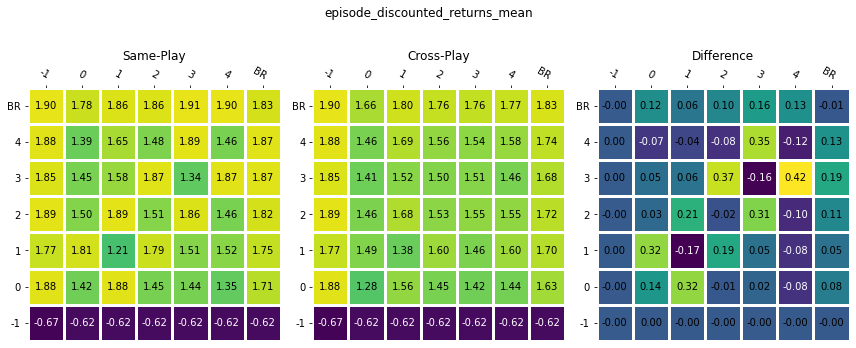

In [5]:
plot_utils.plot_mean_pairwise_comparison(rl_df, "episode_discounted_returns_mean", vrange=(-0.7, 2.0))
plt.show()

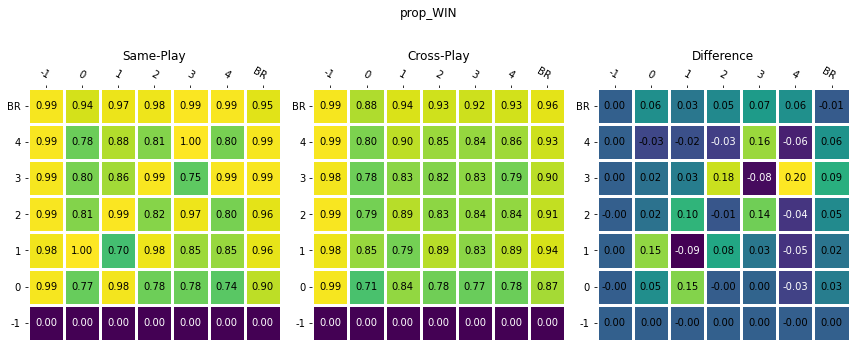

In [6]:
plot_utils.plot_mean_pairwise_comparison(rl_df, "prop_WIN", vrange=(0.0, 1.0))
plt.show()

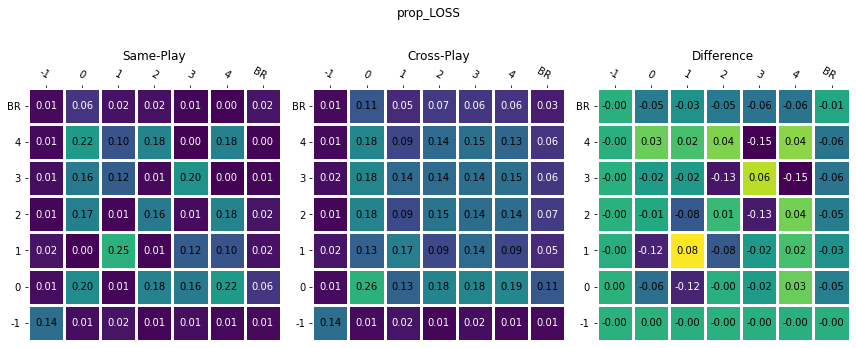

In [7]:
# Proportion of episodes the row agent crashed. I.e. the collision rate.
plot_utils.plot_mean_pairwise_comparison(rl_df, "prop_LOSS", vrange=(0.0, 0.4))
plt.show()

### Example recorded episodes

In [ ]:
# plot_utils.plot_pairwise_policy_comparison(
#     rl_df, 
#     y_key="exp_id", 
#     vrange=(0.0, 0.0), 
#     figsize=(20, 20), 
#     valfmt="{x:.0f}", 
#     average_duplicates=False
# )

# BAPOSGMCP Analysis

## Averaging data over seeds

First step is to collate all the different seeds of the same experiment parameters.

In [ ]:
group_keys = [
    "agent_id", 
    "K",
    "num_sims", 
    "coplayer_K",
    "coplayer_train_seed",
    "coplayer_num_sims",
    "coplayer_other_seed",
    "train_seed", 
    "train_alg",
    "rollout_K", 
    "rollout_seed",
    "rollout_alg",
    "other_alg",
    "other_seed"
]

groups = ba_df.groupby(group_keys)

new_df = groups["episode_discounted_returns_mean"].mean().reset_index()
new_df["exp_id"] = groups["exp_id"].min().reset_index()["exp_id"]
new_df["num_episodes"] = groups["num_episodes"].sum().reset_index()["num_episodes"]
new_df["episode_steps_mean"] = groups["episode_steps_mean"].mean().reset_index()["episode_steps_mean"]
new_df["episode_times_mean"] = groups["episode_times_mean"].mean().reset_index()["episode_times_mean"]
new_df["prop_WIN"] = groups["prop_WIN"].mean().reset_index()["prop_WIN"]

new_df.sort_values(["agent_id", "num_sims"], inplace=True)

print(new_df)
print(new_df["K"].unique())

In [ ]:
plot_ba_values_by_rollout_K(
    new_df, 
    y_key="episode_discounted_returns_mean", 
    include_rl_comparison=True, 
    plot_rl_df=rl_df,
    vrange=(-0.2, 1.0),
    figsize=(12, 6)
)
plt.show()

In [ ]:
plot_ba_values_by_rollout_K(
    new_df, 
    y_key="prop_WIN", 
    include_rl_comparison=True, 
    plot_rl_df=rl_df,
    vrange=(-0.2, 1.0),
    figsize=(12, 6)
)
plt.show()

In [ ]:
plot_ba_values_by_rollout_K(
    new_df, 
    y_key="num_episodes", 
    include_rl_comparison=False, 
    plot_rl_df=rl_df,
    vrange=(0, 1000),
    figsize=(12, 6)
)
plt.show()

In [ ]:
plot_ba_values_by_rollout_K(
    new_df, 
    y_key="episode_steps_mean", 
    include_rl_comparison=False, 
    plot_rl_df=rl_df,
    vrange=(0, 50),
    figsize=(12, 6)
)
plt.show()

In [ ]:
plot_ba_values_by_rollout_K(
    new_df, 
    y_key="episode_times_mean", 
    include_rl_comparison=False, 
    plot_rl_df=rl_df,
    vrange=(0, 50),
    figsize=(12, 6)
)
plt.show()

In [ ]:
lineplot_ba_values(
    new_df, 
    y_key="episode_discounted_returns_mean",
    y_err_key="episode_discounted_returns_CI",
    rl_comparison_K=["BR"], 
    plot_rl_df=rl_df,
    vrange=(-0.0, 1.5),
    figsize=(14, 6)
)
plt.show()

# BA-NRMCP Beliefs Deeper dive

In the following plots we taker deeper dive into understanding the belief of BA-NRMCP.

For this analysis we restrict ourselves to a single experiment seed (100 episodes total). This is mainly for ease of analysis.

In [ ]:
ba0_df = ba_df[ba_df["seed"] == 0]
plot_utils.validate_and_display(ba0_df, True)

# Result keys relating to agent beliefs
s_acc_key = "state_accuracy"
h_acc_key = "history_accuracy"
pi_distance_key = "action_dist_distance"
bayes_acc_key = "bayes_accuracy"

ba_agent_ids = ba_df[ba_df["K"] == "BA"]["agent_id"].unique()
assert len(ba_agent_ids) == 1, f"{ba_agent_ids=}"
ba_agent_id = ba_agent_ids[0]
cp_agent_id = (ba_agent_id + 1) % 2
print(f"{ba_agent_id=}")

step_limit = int(ba_df["step_limit"].unique()[0])
print(f"{step_limit=}")

num_seeds = len(ba_df["seed"].unique())

print()
for c in ba_df.columns:
    print(c)

In [ ]:
group_keys = [
    "agent_id", 
    "K",
    "num_sims", 
    "coplayer_K",
    "coplayer_train_seed",
    "coplayer_num_sims",
    "coplayer_other_seed",
    "train_seed", 
    "train_alg",
    "rollout_K", 
    "rollout_seed",
    "rollout_alg",
    "other_alg",
    "other_seed"
]

def CI(series):
    return 1.96 * np.std(series) / len(series)

ba_only_df = ba_df[ba_df["K"] == "BA"]

# CHANGE this to control the numsims and coplayer shown
ba_only_df = ba_only_df[(ba_only_df["coplayer_K"] == str(4)) & (ba_only_df["num_sims"] == str(512))]

groups = ba_only_df.groupby(group_keys)
ba_grouped_df = groups.agg([np.mean, np.std, CI]).reset_index()
ba_grouped_df.sort_values(["agent_id", "num_sims"], inplace=True)

print(ba_grouped_df)

In [ ]:
def plot_stepwise_belief_stat(plot_df,
                              y_key: str,
                              ba_agent_id: int,
                              t_max: int,
                              is_cp_stat: bool,
                              y_lims=None):
    """Plot belief state (y_key) for each step."""
    
    def y_next_str(step_num):
        if is_cp_stat:
            return f"{y_key}_{cp_agent_id}_{step_num}"
        return f"{y_key}_{step_num}"
    
    ba_agent_seeds = plot_df["rollout_seed"].unique()
    ba_agent_seeds.sort()
    
    cp_agent_seeds = plot_df["coplayer_train_seed"].unique()
    cp_agent_seeds.sort()
    
    num_sims_all = plot_df["num_sims"].unique()
    num_sims_all = [int(n) for n in num_sims_all]
    num_sims_all.sort()
    
    xs = list(range(t_max))
    
    sp_df = plot_df[plot_df[["rollout_seed", "coplayer_train_seed"]].nunique(axis=1) == 1]
    xp_df = plot_df[plot_df[["rollout_seed", "coplayer_train_seed"]].nunique(axis=1) != 1]
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), squeeze=True)
    for num_sims in num_sims_all:
        for ax, ax_df in zip(axs, (sp_df, xp_df)):
            line_df = ax_df[ax_df["num_sims"] == str(num_sims)]

            ys = np.array([line_df[y_next_str(t)]["mean"].tolist()[0] for t in range(t_max)])
            ys_ci = np.array([line_df[y_next_str(t)]["CI"].tolist()[0] for t in range(t_max)])
        
            ax.plot(xs, ys, label=num_sims)
            ax.fill_between(xs, ys-ys_ci, ys+ys_ci)
            
    if y_lims is None:
        y_lims = (-0.00, 1.0)
    
    axs[0].set_ylabel(y_key)
    axs[0].set_xlabel("Step")
    axs[0].set_title("Same-Play")
    axs[0].set_ylim(y_lims)
    axs[0].legend()
    
    axs[1].set_ylabel(y_key)
    axs[1].set_xlabel("Step")
    axs[1].set_title("Cross-Play")
    axs[1].set_ylim(y_lims)
    
    fig.tight_layout()

In [ ]:
# Belief accuracy for the environment state
plot_stepwise_belief_stat(ba_grouped_df, s_acc_key, ba_agent_id, step_limit, False, y_lims=(-0.001, 1.01))
plt.plot()

In [ ]:
# Belief accuracy for the history of the other agent
plot_stepwise_belief_stat(ba_grouped_df, h_acc_key, ba_agent_id, step_limit, True,  y_lims=(-0.001, 1.01))
plt.plot()

In [ ]:
# Belief distance for the action of the other agent
plot_stepwise_belief_stat(ba_grouped_df, pi_distance_key, ba_agent_id, step_limit, True, y_lims=(-0.001, 2.0))
plt.plot()

In [ ]:
# Belief accuracy for the nesting level of the other agent
plot_stepwise_belief_stat(ba_grouped_df, bayes_acc_key, ba_agent_id, step_limit, True, y_lims=(-0.001, 1.01))
plt.plot()